In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

code to convert txt to csv

In [4]:

input_file = r'D:\Thesis\Example_accelerometer\dataset\UPDOWN.txt'
output_file = r'D:\Thesis\Example_accelerometer\dataset\UPDOWN.csv'
with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['accx', 'accy', 'accz', 'label'])
    for line in infile:
        data = line.strip().split(',')
        writer.writerow(data)
print(f"Conversion complete. Output saved to {output_file}")

Conversion complete. Output saved to D:\Thesis\Example_accelerometer\dataset\UPDOWN.csv


Preprocessing - MinMax Normalization and Segmentation

In [6]:
def normalize_data(data, min_value=-1, max_value=1):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    normalized_data = (data - data_min) / (data_max - data_min)  
    normalized_data = normalized_data * (max_value - min_value) + min_value
    return normalized_data


In [7]:
def segment_data(data, window_size, overlap):
    step = int(window_size * (1 - overlap))
    segments = []
    labels = []

    for start in range(0, len(data) - window_size + 1, step):
        end = start + window_size
        segment = data[start:end, :-1]
        label = data[start:end, -1]
        segments.append(segment)
        labels.append(label[0])
    return np.array(segments), np.array(labels)

Combining 2 csv files to single csv file.

In [8]:
df1 = pd.read_csv(r'D:\Thesis\Example_accelerometer\dataset\IDLE.csv')
df2 = pd.read_csv(r'D:\Thesis\Example_accelerometer\dataset\UPDOWN.csv')
data = pd.concat([df1, df2], ignore_index=True)
data.to_csv('D:\Thesis\Example_accelerometer\dataset\combined_dataset.csv', index=False)

Checking for 'Null' values in the dataset to prevent from anomalies during normalization.

In [9]:
print(data.isnull().sum())
print(np.isinf(data[['accx', 'accy', 'accz']].values).sum()) 


accx     0
accy     0
accz     0
label    0
dtype: int64
0


In [10]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()  


In [11]:
print("Min values:", np.min(data[['accx', 'accy', 'accz']].values, axis=0))
print("Max values:", np.max(data[['accx', 'accy', 'accz']].values, axis=0))


Min values: [-2896 -1328 10224]
Max values: [ 2960  2320 23040]


In [12]:
normalized_data = normalize_data(data[['accx', 'accy', 'accz']].values)

data[['accx', 'accy', 'accz']] = normalized_data

In [ ]:
np.set_printoptions(threshold=np.inf)

normalized_data

In [15]:

sampling_rate = 10  
window_duration = 1  
window_size = sampling_rate * window_duration  
overlap = 0.5
segments, labels = segment_data(data.values, window_size, overlap)
print("Number of segments:", len(segments))
print("Shape of each segment:", segments[0].shape)


Number of segments: 408
Shape of each segment: (10, 3)


In [16]:
def save_segments_to_csv(segments, labels, filename):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for segment, label in zip(segments, labels):
            row = segment.flatten().tolist() + [label]
            writer.writerow(row)
save_segments_to_csv(segments, labels, 'D:\Thesis\Example_accelerometer\dataset\segmented_data.csv')

In [17]:
data = pd.read_csv(r'D:\Thesis\Example_accelerometer\dataset\segmented_data.csv', header=None)
segments = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

In [19]:
segments = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

In [20]:
num_segments, window_size = segments.shape
segments = segments.reshape((num_segments, window_size // 3, 3))

In [21]:
if len(segments.shape) == 3:
    num_segments, window_size, num_features = segments.shape
else:
    raise ValueError("Unexpected shape of segments array")

In [22]:
print("Number of segments:", num_segments)
print("Shape of each segment:", segments[0].shape)

Number of segments: 408
Shape of each segment: (10, 3)


In [23]:
segments.shape

(408, 10, 3)

In [25]:
import sklearn
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=42)


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout


In [31]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


Just a heads-up, checked the model prediction during Inference, and it is not an overfitted model.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 8, 64)             640       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               25700     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                      

11/11 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9939 - val_loss: 0.0086 - val_accuracy: 1.0000


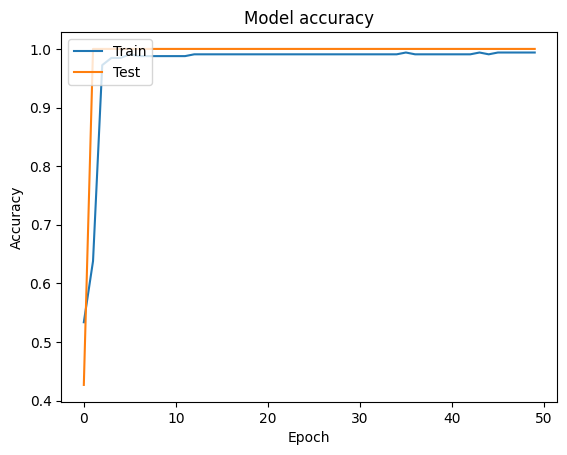

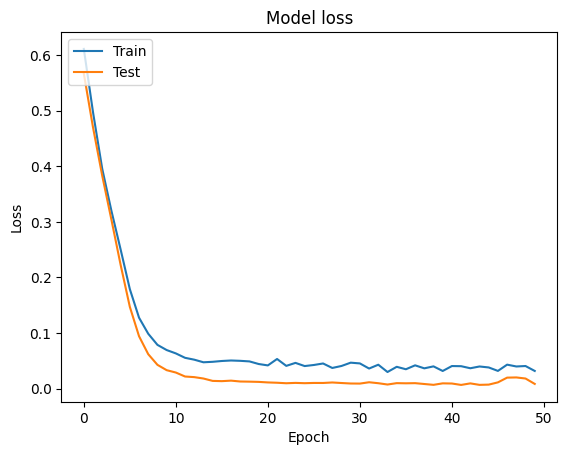

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Converting the model to quantized version, to save possible memory allocations (for Inferencing in STM32).

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open('D:\Thesis\Example_accelerometer\model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)
print("Quantized model saved as model_quantized.tflite")

INFO:tensorflow:Assets written to: C:\Users\visha\AppData\Local\Temp\tmpgyd8szvn\assets


INFO:tensorflow:Assets written to: C:\Users\visha\AppData\Local\Temp\tmpgyd8szvn\assets


Quantized model saved as model_quantized.tflite
